In [118]:
#Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
from string import punctuation
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from wordcloud import WordCloud, STOPWORDS

In [2]:
import missingno as msno 

In [3]:
# !pip install emot
# import emot

### Reading the data

In [4]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (7613, 5)
Test shape :  (3263, 4)


### Overview of both train and test data sets 

In [5]:
pd.set_option('display.max_colwidth', 999)


1. **Train Data Set**

In [6]:
train_df.sample(5)

,id,keyword,location,text,target
4034,5729,forest%20fire,NaN,5:15p For those who watch over me forest fire smoke has lifted 'nuff f/me t/make a run t/the pet store on the hwy (N). I'll b/home by 7p.,1
1602,2312,collapse,"Jubail IC, Saudi Arabia",@BasilDudin The 'barbaric Saudies' as you said they relive Austrian economy. If we stop coming here many project will collapse.,0
4865,6928,mass%20murderer,Chester Football Club,@VictoriaGittins what do you take me for I'm not a mass murderer! Just the one...,0
5030,7173,mudslide,plymouth,@brobread looks like mudslide????,1
477,687,attack,NaN,Heart disease prevention: What about secondhand smoke? http://t.co/YdgMGBrYL2,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Number of missing values

In [8]:
def missing_values(df):
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['missing values count', '%']
    return missing.sort_values(by='missing values count', ascending=False)
missing_values(train_df)

,missing values count,%
location,2533,33.272035
keyword,61,0.801261
id,0,0.000000
text,0,0.000000
target,0,0.000000


### Number of unique values

In [9]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [10]:
return_unique_values(train_df)

,Features,Uniques
0,id,7613
1,keyword,221
2,location,3341
3,text,7503
4,target,2


2. **Test Data Set**

In [11]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [13]:
missing_values(test_df)

,missing values count,%
location,1105,33.864542
keyword,26,0.796813
id,0,0.000000
text,0,0.000000


In [14]:
import matplotlib as mpl
mpl.style.use('seaborn')

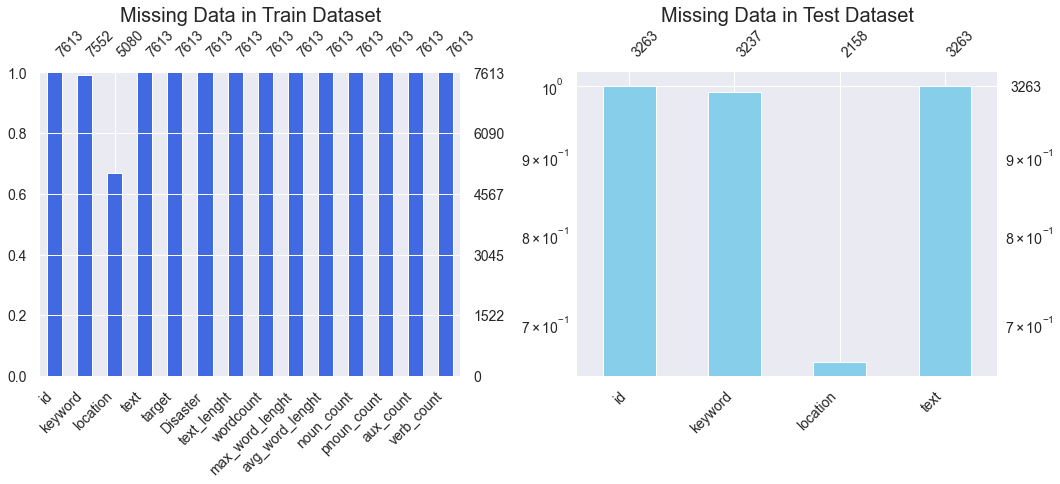

In [119]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
msno.bar(train_df, color="royalblue", fontsize=14, ax=ax1, labels=True, );
ax1.set_title('Missing Data in Train Dataset', fontsize= 20)

ax2 = fig.add_subplot(1,2,2)
msno.bar(test_df, log=True, color="skyblue", fontsize=14, ax=ax2, labels=True);
ax2.set_title('Missing Data in Test Dataset', fontsize= 20)


plt.tight_layout()

In [16]:
return_unique_values(test_df)

,Features,Uniques
0,id,3263
1,keyword,221
2,location,1602
3,text,3243


## Target Distribution in the training dataset

In [17]:
def distribution_bar_plot(feature, df, dataset):

    fig, ax = plt.subplots(figsize=(8, 2))    
    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index, ax=ax, palette='Blues')
    ax.set_title(f'The Percentage Count of "{feature}" on {dataset} set', )
    ax.set_xlabel('Percentage Count')
    ax.set_ylabel(f'{feature}')
    #ax.axis("off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
        
    plt.show()

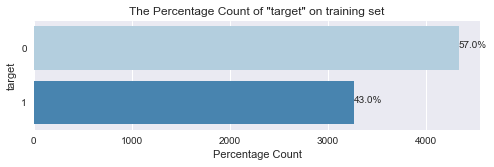

In [18]:
distribution_bar_plot('target', train_df, 'training')

## Check for Duplicates in Training Data Set

1. **The entire training set**

In [19]:
print(f'There are {train_df.duplicated().sum()} duplicates considering all columns in the data set' )

There are 0 duplicates considering all columns in the data set


2. **Check  duplicates in the "text" column**

In [20]:
print(f'There are {train_df["text"].duplicated().sum()} duplicated text in the "text" column' )

There are 110 duplicated text in the "text" column


### We need to make sure that duplicated text values are labeled the same 

3. **Check if duplicates in the "text" column has a consistent target value**

In [21]:
print(f"Out of 110, there are only {train_df[['text', 'target']].duplicated().sum()} of duplicated text labeled the same")

Out of 110, there are only 92 of duplicated text labeled the same


In [22]:
print(f'there are {110 -92} inconsistent labels of the duplicates')

there are 18 inconsistent labels of the duplicates


- Filter text with inconsistent target values

In [23]:
inconsistent_lebeled_subset = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
inconsistent_lebeled_subset = inconsistent_lebeled_subset[inconsistent_lebeled_subset['target'] > 1][['target']]
inconsistent_lebeled_subset

,target
text,
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,2
To fight bioterrorism sir.,2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,2
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,2
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,2


- Review all text with inconsistent target values to be  fixed

In [24]:
inconsistent_lebeled_text= list(inconsistent_lebeled_subset.index)

In [25]:
inconsistent_lebeled_subset = train_df[train_df['text'].isin(inconsistent_lebeled_text)].sort_values(by='text', ascending=False)
inconsistent_lebeled_subset

,id,keyword,location,text,target
5641,8044,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated from Cameroon,0
5620,8018,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated from Cameroon,1
6091,8698,sinking,Every Where in the World,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,1
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,1
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,0
1221,1760,buildings%20burning,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1349,1950,burning%20buildings,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0
4019,5710,floods,NaN,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,0
4013,5699,floods,NaN,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,0


## Fixing inconsistent labels manually (hard coding) using the author judgment 

In [26]:
train_df['Disaster'] = train_df.loc[:, ['target']]

In [27]:
inconsistent_lebeled_subset.index

Int64Index([5641, 5620, 6091, 6123, 6103, 6094, 1221, 1349, 4019, 4013, 3985,
             624,  610,  634,  630, 4318, 4309, 4304, 4292, 4286, 4284, 4381,
            4379, 1331, 1197, 6614, 6616, 1214, 1365, 4320, 4306, 4285, 4305,
            4313, 3240, 3266, 3261, 3251, 3248, 3243, 4232, 4235, 4605, 4618,
            4597, 2831, 2832, 2830, 2833, 4239, 4221, 4244, 4312, 4299, 4290],
           dtype='int64')

In [28]:
train_df.iloc[[5641, 5620], 5] = 0
train_df.iloc[[6091, 6123, 6103, 6094,], 5] = 0
train_df.iloc[[1221, 1349], 5] = 0
train_df.iloc[[4019, 4013, 3985], 5] = 0
train_df.iloc[[624,  610,  634,  630], 5] = 0
train_df.iloc[[4318, 4309, 4304, 4292, 4286, 4284], 5] = 0
train_df.iloc[[4381, 4379], 5] = 1
train_df.iloc[[1331, 1197], 5] = 1
train_df.iloc[[6614, 6616], 5] = 0
train_df.iloc[[1214, 1365], 5] = 1
train_df.iloc[[4320, 4306], 5] = 0
train_df.iloc[[4285, 4305, 4313], 5] = 0
train_df.iloc[[3240, 3266, 3261, 3251, 3248, 3243], 5] = 0
train_df.iloc[[4232, 4235], 5] = 0
train_df.iloc[[4605, 4618, 4597], 5] = 1
train_df.iloc[[2831, 2832, 2830, 2833], 5] = 1
train_df.iloc[[4239, 4221, 4244], 5] = 1
train_df.iloc[[4312, 4299, 4290], 5] = 1

- Checking target consistency of duplicated text

In [29]:
train_df[['text']].duplicated().sum()

110

In [30]:
train_df[['text', 'Disaster']].duplicated().sum()

110

**All duplicated text have a consistent target values.**

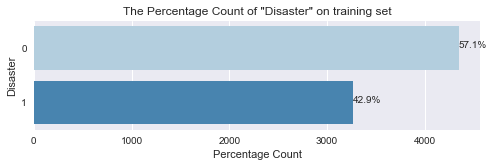

In [31]:
distribution_bar_plot('Disaster', train_df, 'training')

The distribution of the target values changes by 0.1% after fixing the inconsistency in the target values for the duplicates.

## Inspecting the "location" feature

In [32]:
# Calculating missing values
missing_values(train_df[['location']])

,missing values count,%
location,2533,33.272035


### a view of some unique locations in the data set

In [33]:
train_df[['location']].nunique()

location    3341
dtype: int64

In [34]:
print(np.random.choice(train_df['location'].unique(),20))

['Milwaukee WI' 'Toronto, ON, Canada' 'Peshawar' '10-Jul' 'Thane' '627'
 'w. Nykae ' 'Yellowknife, NT' 'Manhattan, NY' '10 Steps Ahead.  Cloud 9'
 'i love the smurfs 2' 'Fresno' 'Midwestern USA' 'the burrow'
 'Detroit/Windsor' 'University of Toronto'
 ' ? ??????? ? ( ?? å¡ ? ? ? å¡)' 'London/Bristol/Guildford' 'MÌ©xico'
 '[Gia.] | #KardashianEmpire']


In [35]:
def frequency_counts(feature, df=train_df):
    ''' Calculates the count and percentage of each value of column'''
    counts = pd.concat([df[feature].value_counts(), round(100 * df[feature].value_counts()/df.shape[0], 2)], axis=1)
    counts.columns=['count', '% of dataset']
    counts.reset_index(inplace =True)
    counts.rename(columns={'index': feature}, inplace=True)
    return counts

In [36]:
frequency_counts(['location'], df=train_df)

,location,count,% of dataset
0,USA,104,1.37
1,New York,71,0.93
2,United States,50,0.66
3,London,45,0.59
4,Canada,29,0.38
...,...,...,...
3336,Republica Dominicana,1,0.01
3337,Republic of the Philippines,1,0.01
3338,Regalo Island,1,0.01
3339,"Redondo Beach, CA",1,0.01


## Insights:
- 33% of the location feature is missing.
- The are 3341 unique location for the tweets.
- The location in this data set is not consistent. We see some tweets' location as a country and others as a city. 

- the USA is the most frequent location for the tweets, followed by New York, then united states representing (1.37%, 0.93%, and 0.66%) of the tweets respectively.
- **However, With this large number of missing values, it is not feasible to clean the location values. The location in this data set is not good to be predictive feature and will not be considered in the modeling.**

## Inspecting the "keyword" feature

1. **Missing values**

In [37]:
# Calculating missing values
print('Missing values of keyword in train dataset:')
missing_values(train_df[['keyword']])

Missing values of keyword in train dataset:


,missing values count,%
keyword,61,0.801261


In [38]:
# Calculating missing values
print('Missing values of keyword in test dataset:')
missing_values(test_df[['keyword']])

Missing values of keyword in test dataset:


,missing values count,%
keyword,26,0.796813


2. **Unique Values**

In [39]:
print("The number of unique keywords in train set tweets is:", train_df['keyword'].nunique())
print("The number of unique keywords in test set tweets is:", test_df['keyword'].nunique())

The number of unique keywords in train set tweets is: 221
The number of unique keywords in test set tweets is: 221


### Keyword frequency count along with their percentage appearance of the dataset

* **Note: The frequency count and percentage are calculated based on a particular class (Disaster or No Disaster) size not all the data set.**

In [40]:
print('most fequent 15 keywords in train dataset:')
frequency_counts(['keyword'], df=train_df).set_index('keyword')[:15]

most fequent 15 keywords in train dataset:


,count,% of dataset
keyword,,
fatalities,45,0.59
deluge,42,0.55
armageddon,42,0.55
body%20bags,41,0.54
sinking,41,0.54
damage,41,0.54
harm,41,0.54
outbreak,40,0.53
fear,40,0.53


In [41]:
print('most fequent 15 keywords in test dataset:')
frequency_counts(['keyword'], df=test_df).set_index('keyword')[:15]

most fequent 15 keywords in test dataset:


,count,% of dataset
keyword,,
deluged,23,0.70
rubble,22,0.67
demolished,22,0.67
first%20responders,21,0.64
obliteration,21,0.64
seismic,21,0.64
sirens,21,0.64
snowstorm,21,0.64
annihilation,21,0.64


### Keyword Count, Percentage and Probability of indicating a Disaster Tweet

In [42]:
def kw_distribution(df, feature): 
    """this function returns word cuonts, keywords percentage in dataset rows,
    and the keyword probability off indicating disater tweet"""
    counts = pd.concat([df[feature].value_counts(), round(100 * df[feature].value_counts()/df.shape[0], 2)], axis=1)
    counts.columns=['count', '% of dataset rows']
    prop = df.groupby(feature).agg({'Disaster':np.mean}).rename(columns={'Disaster':'Probability of Disaster'})
    joined = counts.join(prop).sort_values('Probability of Disaster', ascending=False)
    joined.index.rename('keyword', inplace=True)
    return joined

In [43]:
print('Top 15 keywords with highest probability of indicating disaster tweet')
kw_distribution(train_df, 'keyword')[:15]

Top 15 keywords with highest probability of indicating disaster tweet


,count,% of dataset rows,Probability of Disaster
keyword,,,
wreckage,39,0.51,1.000000
debris,37,0.49,1.000000
derailment,39,0.51,1.000000
outbreak,40,0.53,0.975000
oil%20spill,38,0.50,0.973684
typhoon,38,0.50,0.973684
suicide%20bombing,33,0.43,0.969697
suicide%20bomber,31,0.41,0.967742
bombing,29,0.38,0.931034


In [44]:
print('Top 15 keywords with lowest probability of indicating None Disaster tweet')
kw_distribution(train_df, 'keyword').sort_values('Probability of Disaster')[:15]

Top 15 keywords with lowest probability of indicating None Disaster tweet


,count,% of dataset rows,Probability of Disaster
keyword,,,
aftershock,34,0.45,0.000000
body%20bags,41,0.54,0.024390
ruin,37,0.49,0.027027
blazing,34,0.45,0.029412
body%20bag,33,0.43,0.030303
electrocute,32,0.42,0.031250
screaming,36,0.47,0.055556
traumatised,35,0.46,0.057143
blew%20up,33,0.43,0.060606


### Plotting keywords distribution of frequency count and percentage across classes (disaster = 1 colored  blue, none disaster = 0 colored orange)

* **Note: The frequency count and percentage are calculated based on the entire data set.**

In [45]:
def distribution_bar_plot(feature, df, dataset):

    fig, ax = plt.subplots(figsize=(15, 85), dpi=100)    
    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[df['Disaster'] == 1][feature].value_counts().index, ax=ax, hue='Disaster', palette='RdBu')
    ax.set_title(f'The Percentage Count of "{feature}" in {dataset} set', )
    ax.set_xlabel('Percentage Count')
    ax.set_ylabel(f'{feature}')
    #ax.axis("off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    ax.tick_params(axis='y', labelsize=14)
    plt.show()

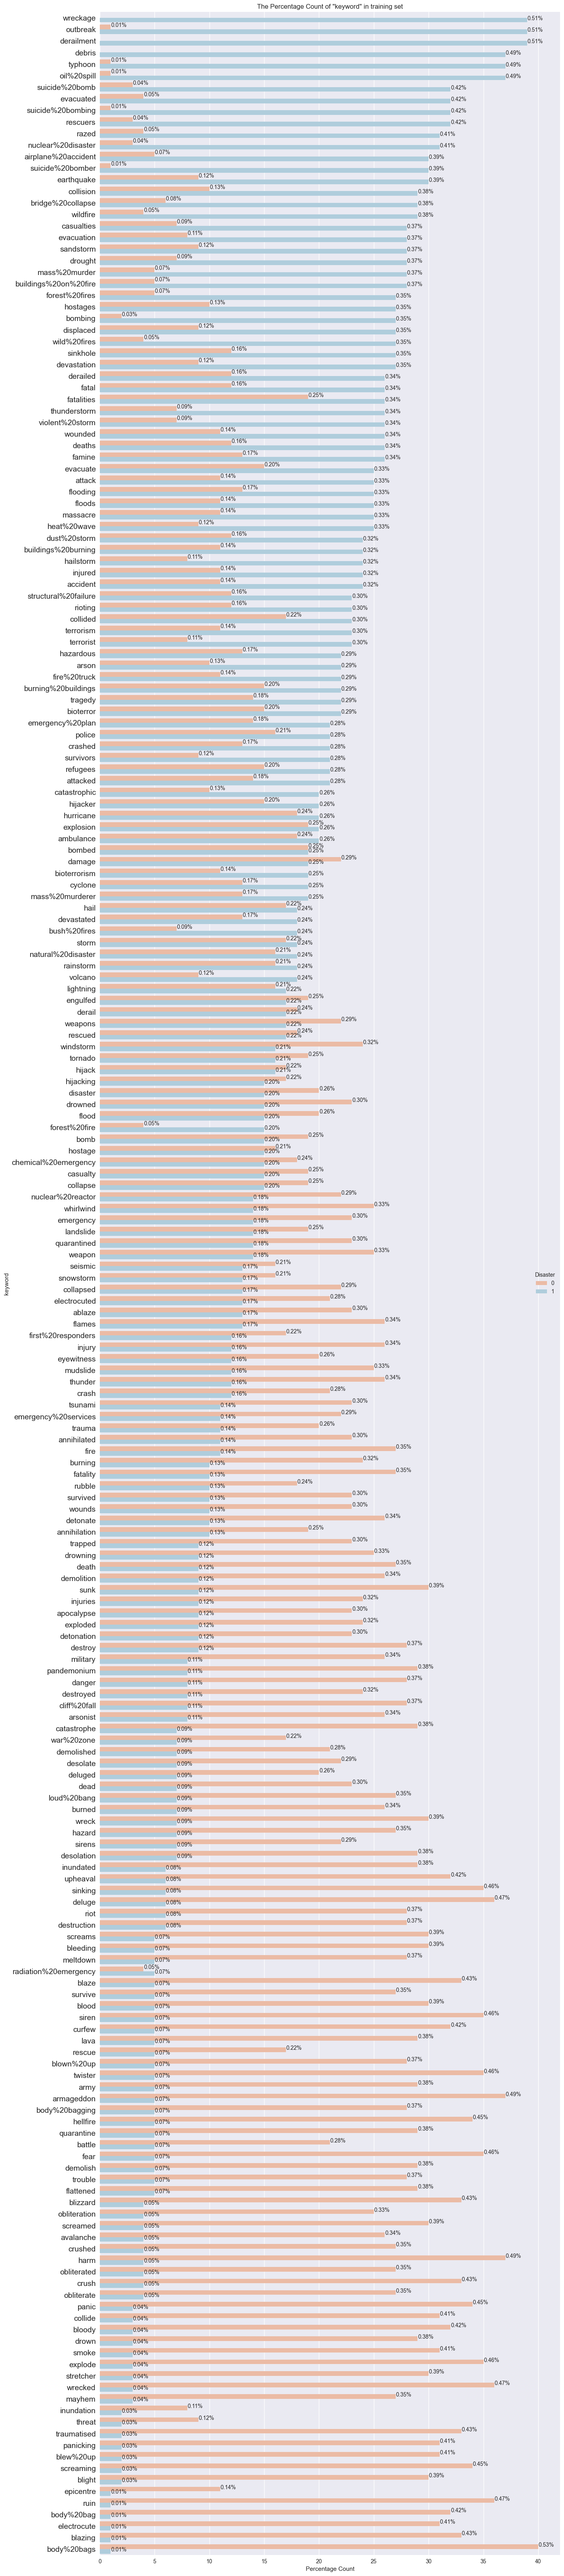

In [46]:
distribution_bar_plot('keyword', train_df, 'training')

## Insights:
- There are 61 (0.8%) missing keywords in this dataset.
- the keywords derailment, wreckage, and debris are only appeared in the disaster tweets with disaster probability = 1. Also, outbreak, typhoon, oil%20omb, suicide%20bombing and rescuers has more than 90% probability of indicating disaster tweet.
- keywords like aftershock, body%20bags, ruin, blazing, body%20bag, electrocute, screaming, traumatised, and blew%20up are mostly appeared in the none disaster tweets where indicating near zero probability of disaster tweets.
- there are many other keywords that are existed in both classes. The keyword without the context can not be a good predictive of the disaster tweets.

## Inspecting the "text" feature

### Plotting Words Cloud
plotting word cloud before cleaning the data, only removing stopping words.

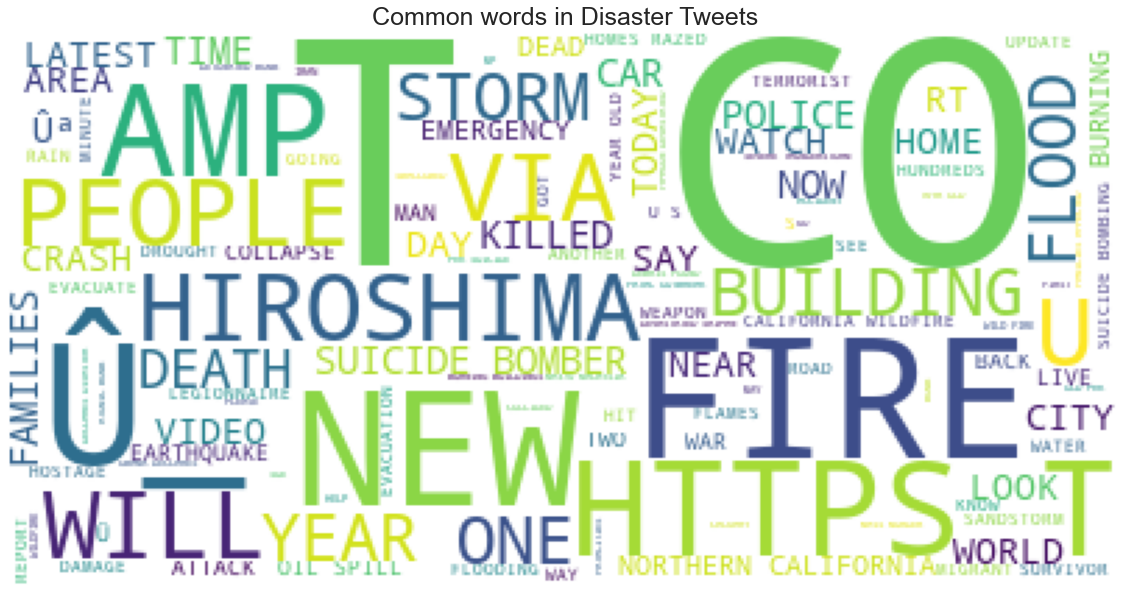

In [47]:
def cloud(text, target):
    plt.subplots(figsize=(20, 30))
    wordcloud = WordCloud(background_color="white",stopwords=STOPWORDS).generate(" ".join([i for i in text.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Common words in {target} Tweets", fontsize=25)
cloud(train_df[train_df.Disaster == 1]['text'], 'Disaster' )

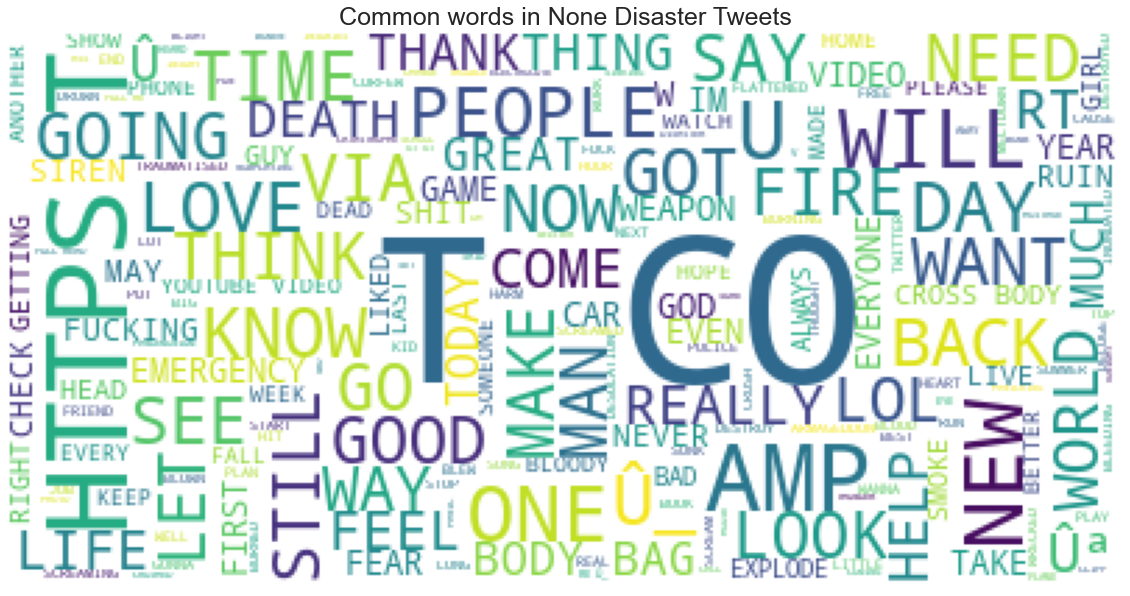

In [48]:
cloud(train_df[train_df.Disaster == 0]['text'], 'None Disaster' )

## **Meta Data Analysis**

### Tweets length (number of characters) distribution for Disaster and None Disaster classes

In [49]:
# add text_lenght column to the train dataset
train_df['text_lenght'] = train_df.loc[:, 'text'].apply(len)

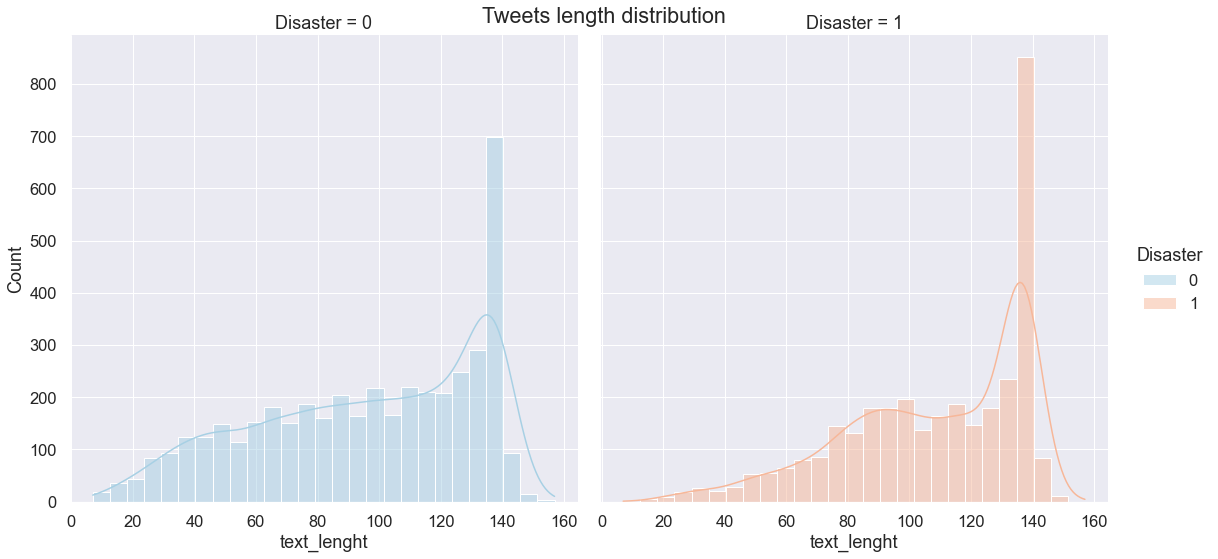

In [50]:
sns.set(font_scale = 1.5)

plot = sns.displot(train_df, x="text_lenght", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle("Tweets length distribution");

### Word count distribution for tweets

In [51]:
# add text_lenght column to the train dataset
train_df['wordcount'] = train_df.loc[:, 'text'].apply(lambda x: len(str(x).split()))

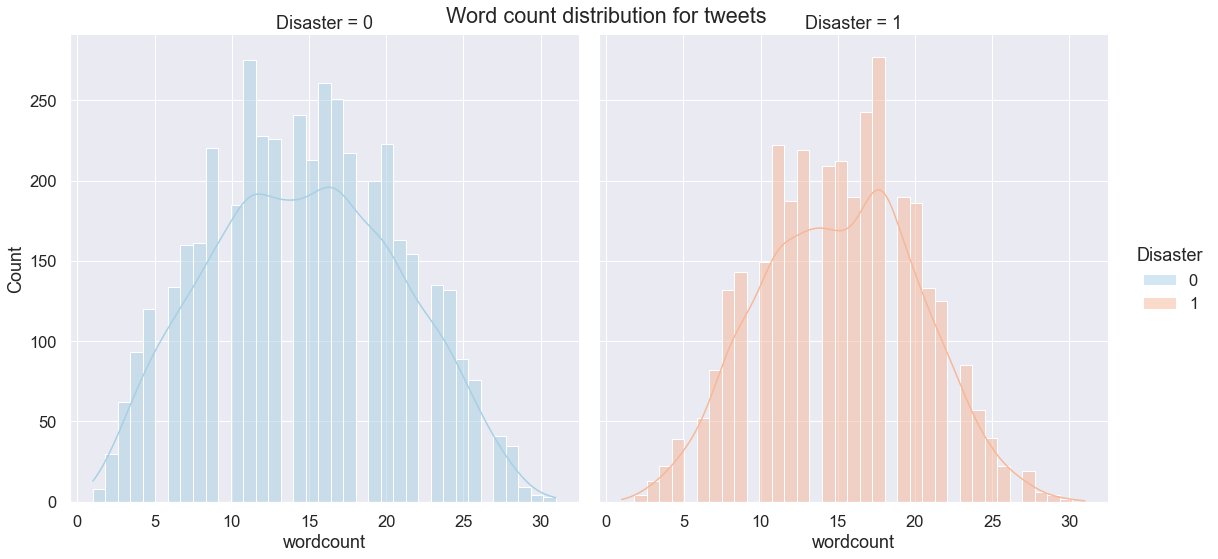

In [52]:
plot = sns.displot(train_df, x="wordcount", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle(" Word count distribution for tweets");

### Average and Maximum word length in a tweet

In [53]:
train_df['max_word_lenght']= train_df['text'].str.split().apply((lambda x : max([len(i) for i in x])))
train_df['avg_word_lenght']= train_df['text'].str.split().apply((lambda x : np.mean([len(i) for i in x])))

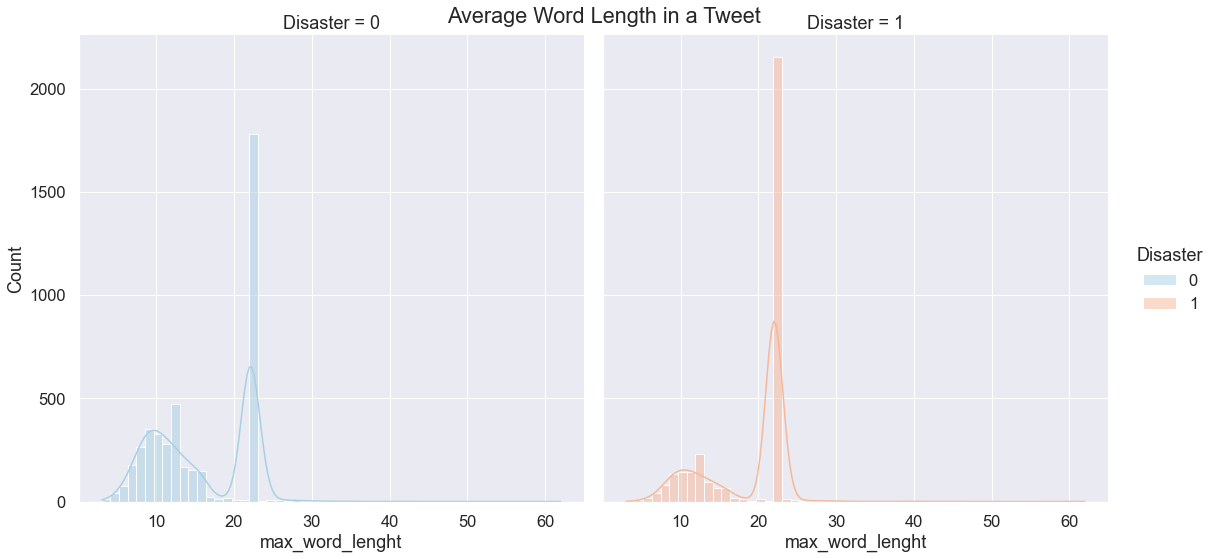

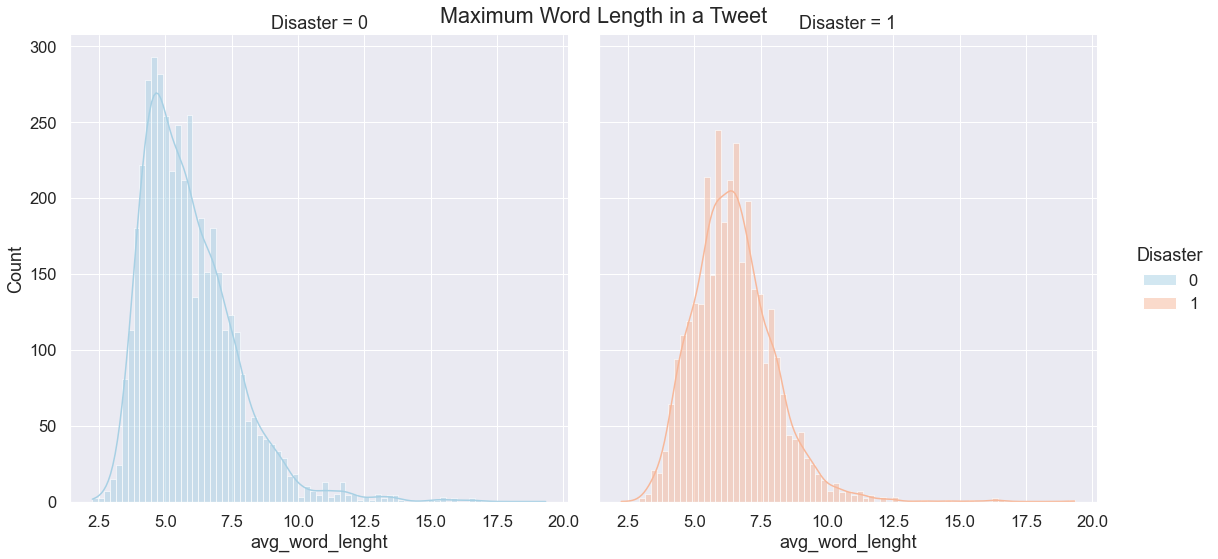

In [54]:
plot = sns.displot(train_df, x="max_word_lenght", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle("Average Word Length in a Tweet")
plot = sns.displot(train_df, x="avg_word_lenght", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle("Maximum Word Length in a Tweet");

## Insights:
- The Meta data features of both classes have a similar distribution.
- None of these Meta data features seems to be a good predictor of the disaster tweets.
- We will further check the predictive power of these features later in this analysis.

## **Exploring Common Words and Phrases**

### Common Words using N_Gram

In [93]:
# thanks to: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_words(corpus, ngram=1, stop_words=None, n=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


### 1.1 The distribution of top unigrams before removing stop words

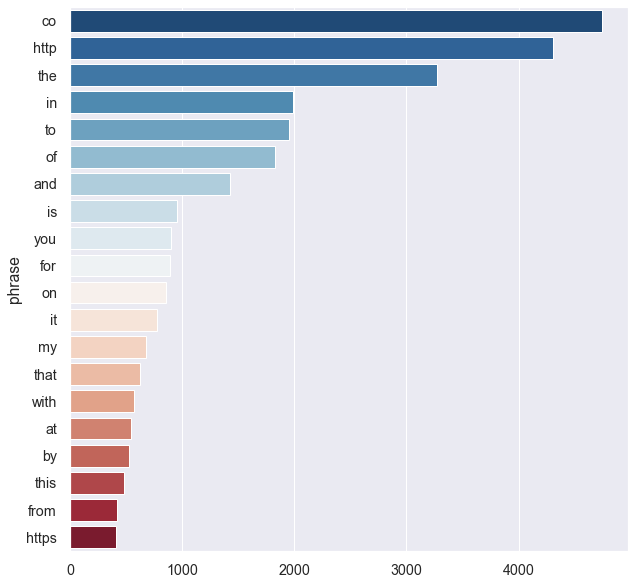

In [112]:
common_words = get_top_n_words(train_df['text'], n=20)

df1 = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
df1 = df1.groupby('phrase').sum()['count'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y = df1.index, x = df1.values, palette='RdBu_r', ax=ax);

### 1.2 The distribution of top unigrams after removing stop words

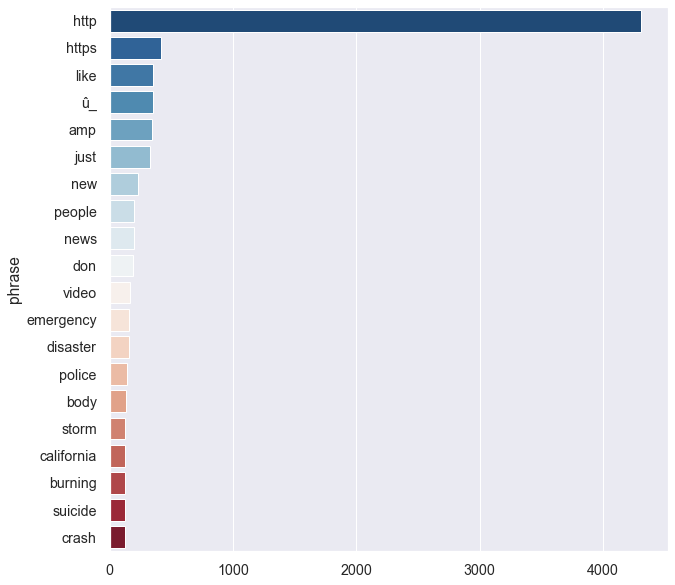

In [113]:
common_words = get_top_n_words(train_df['text'], ngram=1, stop_words='english', n=20)

df1 = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
df1 = df1.groupby('phrase').sum()['count'].sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y = df1.index, x = df1.values, palette='RdBu_r', ax=ax);

### 2.1 The distribution of top bigrams before removing stop words

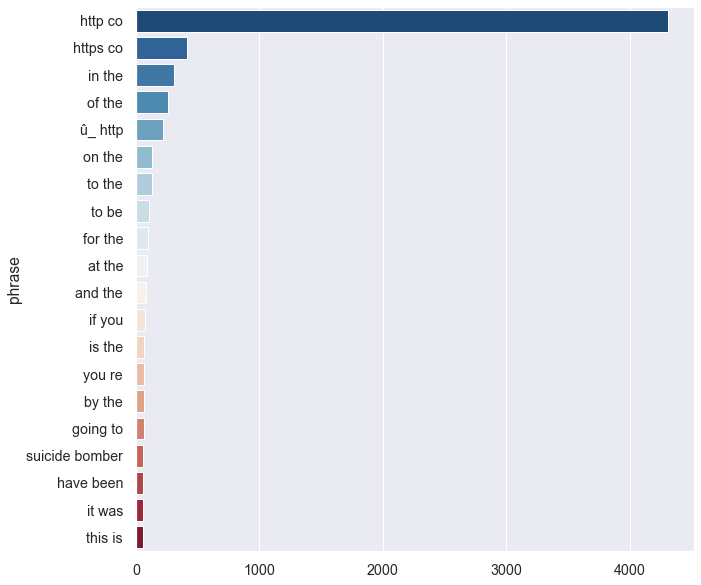

In [114]:
common_words = get_top_n_words(train_df['text'], ngram=2 , n=20)

df1 = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
df1 = df1.groupby('phrase').sum()['count'].sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y = df1.index, x = df1.values, palette='RdBu_r', ax=ax);

### 2.2 The distribution of top bigrams after removing stop words

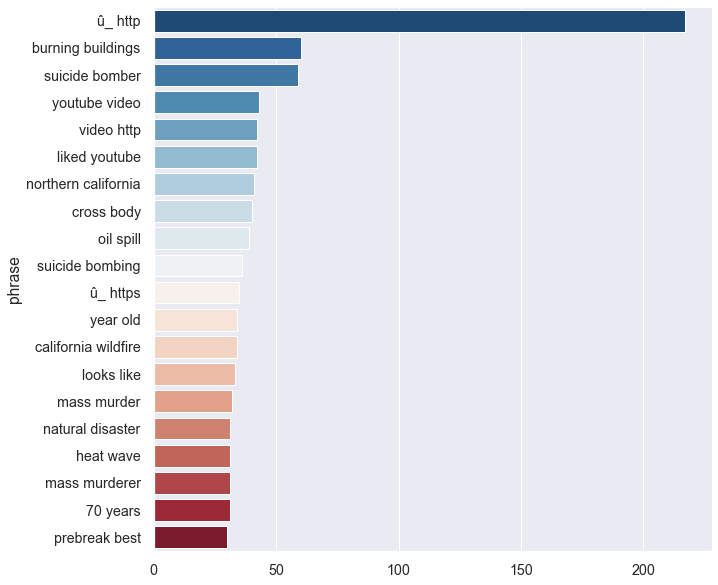

In [115]:
common_words = get_top_n_words(train_df['text'], ngram=2, stop_words='english', n=20)

df1 = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
df1 = df1.groupby('phrase').sum()['count'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y = df1.index, x = df1.values, palette='RdBu_r', ax=ax);

### 3.1 The distribution of Top trigrams before removing stop words

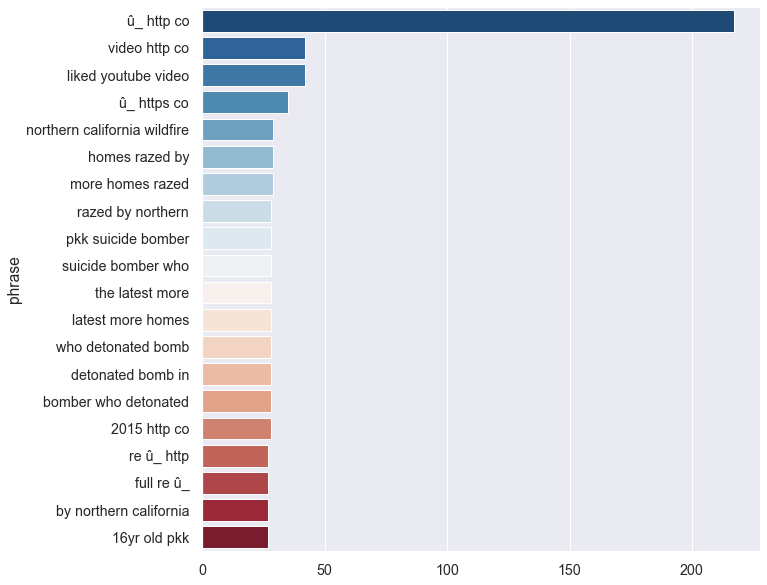

In [116]:
common_words = get_top_n_words(train_df['text'], ngram=3 , n=20)

df1 = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
df1 = df1.groupby('phrase').sum()['count'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y = df1.index, x = df1.values, palette='RdBu_r', ax=ax);

### 3.2 The distribution of Top trigrams after removing stop words

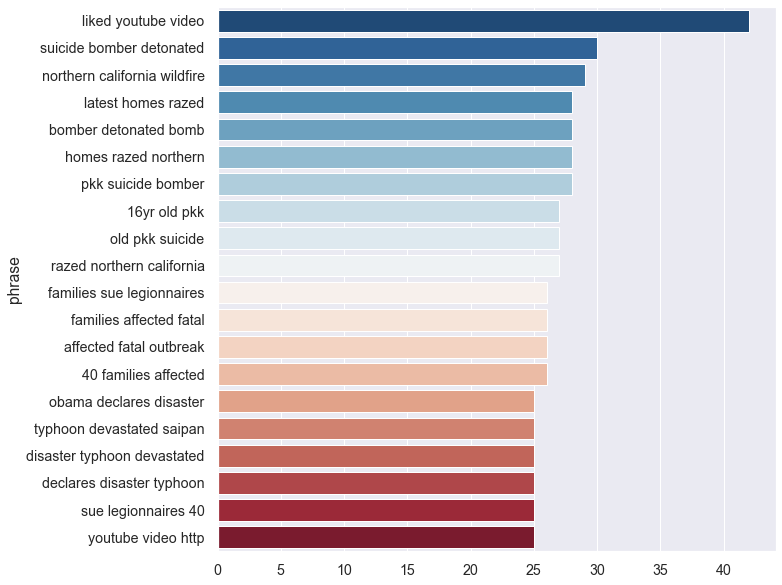

In [117]:
common_words = get_top_n_words(train_df['text'], ngram=3, stop_words='english', n=20)

df1 = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
df1 = df1.groupby('phrase').sum()['count'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y = df1.index, x = df1.values, palette='RdBu_r', ax=ax);

## Insights:
- The data needs to be cleaned from "http", "https", emojis and other noisy characters.
- Common words for each class need to be further explored.


## **Exploring Linguistic Features**


## Part of Speech Analysis using Spacy

In [55]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
import spacy

In [57]:
nlp = spacy.load('en_core_web_lg')

In [58]:
import itertools
def pos(text, model=nlp):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
  
    # Return number of other nouns
    return (pos.count('NOUN'), pos.count('PROPN'), pos.count('AUX'), pos.count('VERB'))


In [59]:
train_df.loc[:, ('noun_count', 'pnoun_count','aux_count', 'verb_count')] = np.array(train_df['text'].apply(pos).tolist())

In [60]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'Disaster',
       'text_lenght', 'wordcount', 'max_word_lenght', 'avg_word_lenght',
       'noun_count', 'pnoun_count', 'aux_count', 'verb_count'],
      dtype='object')

In [61]:
def hit_plot(feature):
    avg_1 = train_df[train_df['Disaster'] == 1][feature].mean()
    avg_0 = train_df[train_df['Disaster'] == 0][feature].mean()
    print(f'\nAverage {feature} for disaster tweet is {avg_1}\nAverage {feature} for none disaster tweet is {avg_0}')
    plot = sns.displot(train_df, x=feature, col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
    plot.fig.suptitle(f"{feature} in a Tweet")
    plt.show()



Average noun_count for disaster tweet is 4.029105392156863
Average noun_count for none disaster tweet is 3.3258220280524258


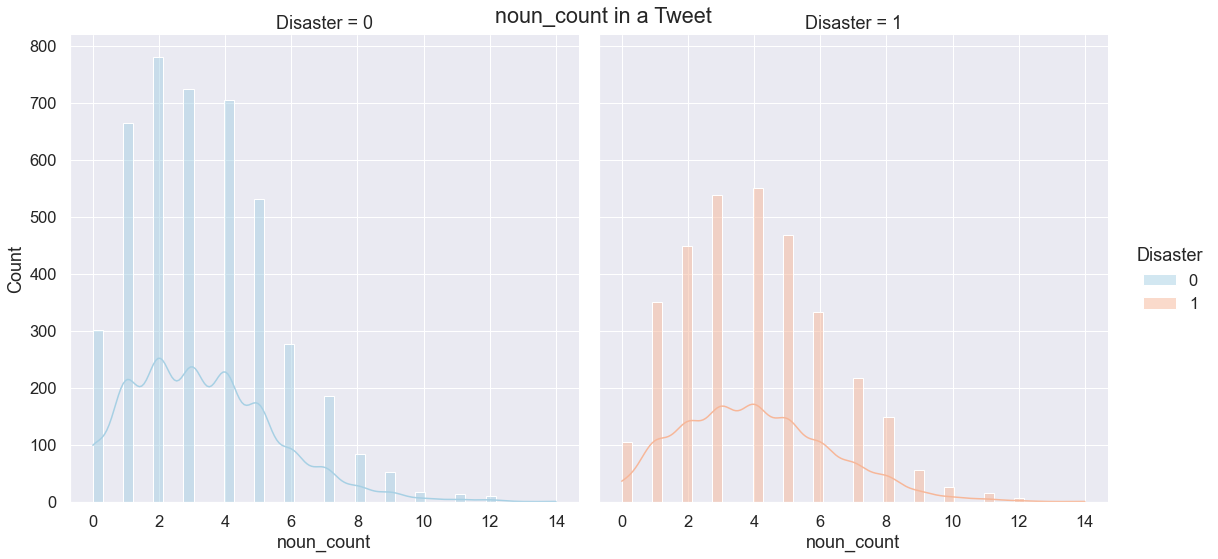


Average pnoun_count for disaster tweet is 3.157781862745098
Average pnoun_count for none disaster tweet is 2.456886640607036


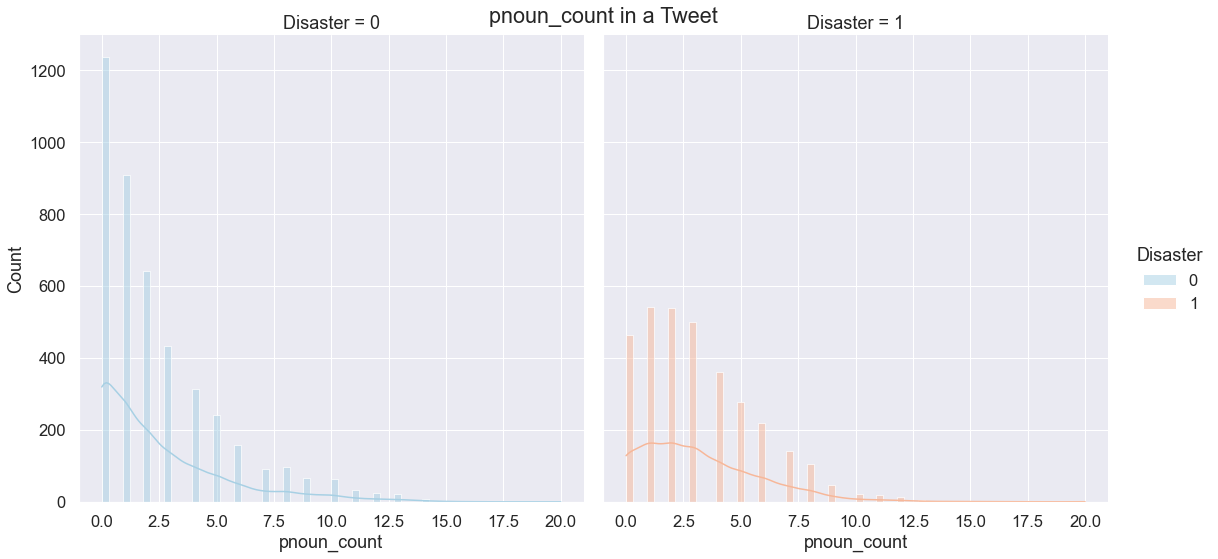


Average aux_count for disaster tweet is 0.5189950980392157
Average aux_count for none disaster tweet is 0.7052195907105082


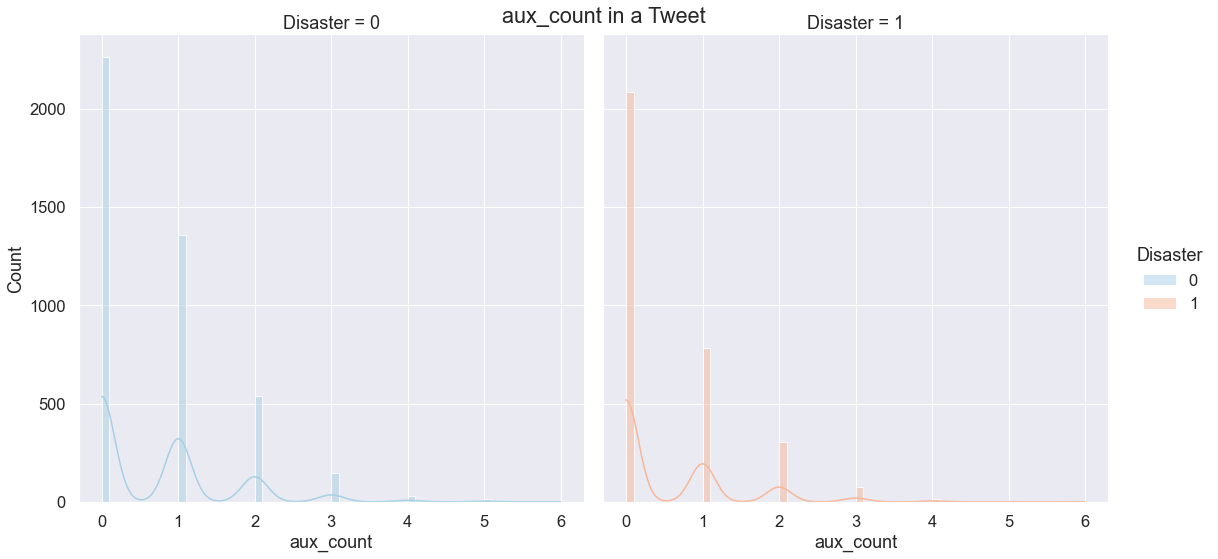


Average verb_count for disaster tweet is 1.9194240196078431
Average verb_count for none disaster tweet is 2.1092205104621753


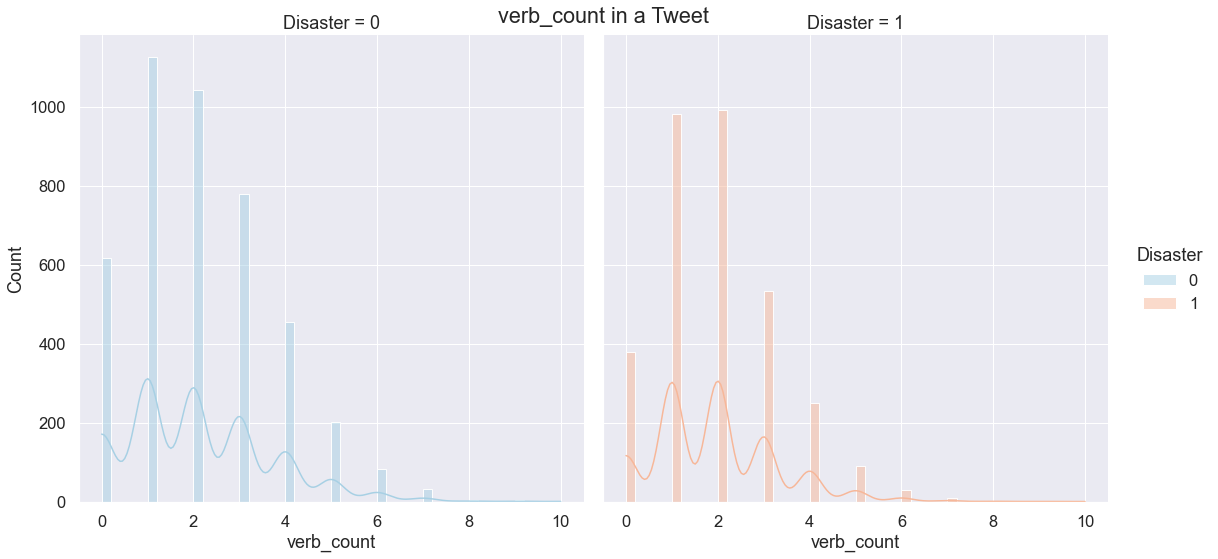

In [62]:

pos_features = ['noun_count', 'pnoun_count','aux_count', 'verb_count']
for feature in pos_features:
    hit_plot(feature)

## Insights:
- The Linguistic Features, except the proper nouns, seems to have similar distribution for both classes.
- The predictive power of these features will be examined next.


## Predictive Power Analysis

In [63]:
import ppscore as pps

In [64]:
def heatmap(df):
    """This function generates the heatmap for the calculated predictive power score (PPS) matrix"""
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    fig, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, annot_kws={"fontsize":13})
    ax.set_title("Predictive Power Score (PPS) matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    plt.show()

In [65]:
train_subset = train_df.drop(['id', 'keyword', 'location', 'text', 'target'], axis=1)

In [66]:
df = pps.matrix(train_subset)

In [67]:
df['ppscore'] = round(df['ppscore'], 2)


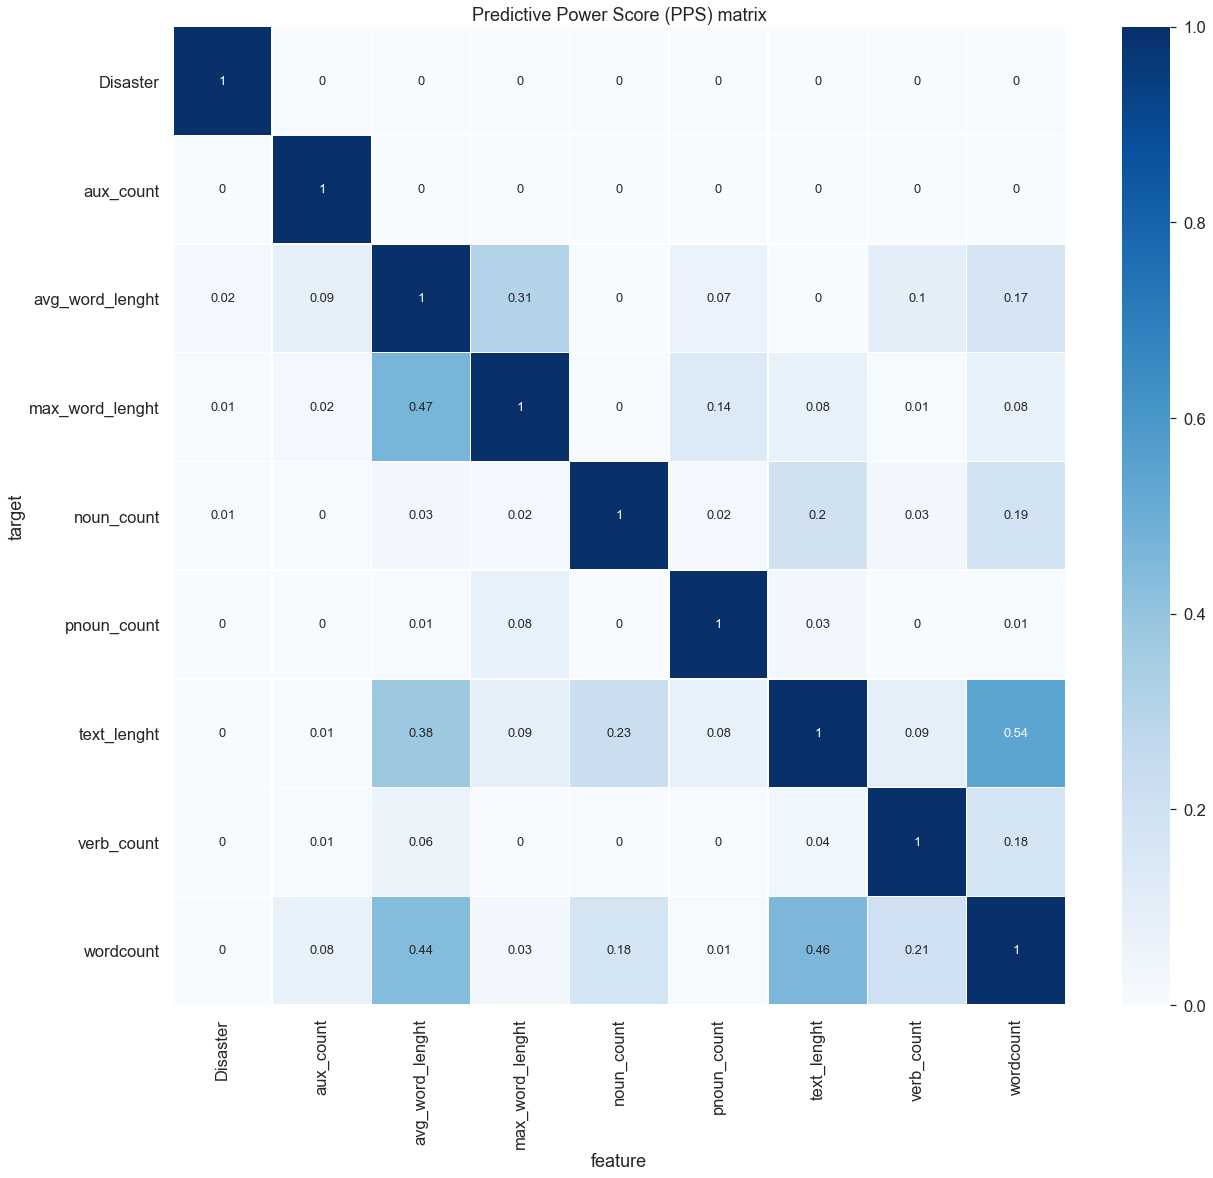

In [68]:
heatmap(df)

### Correlation Analysis

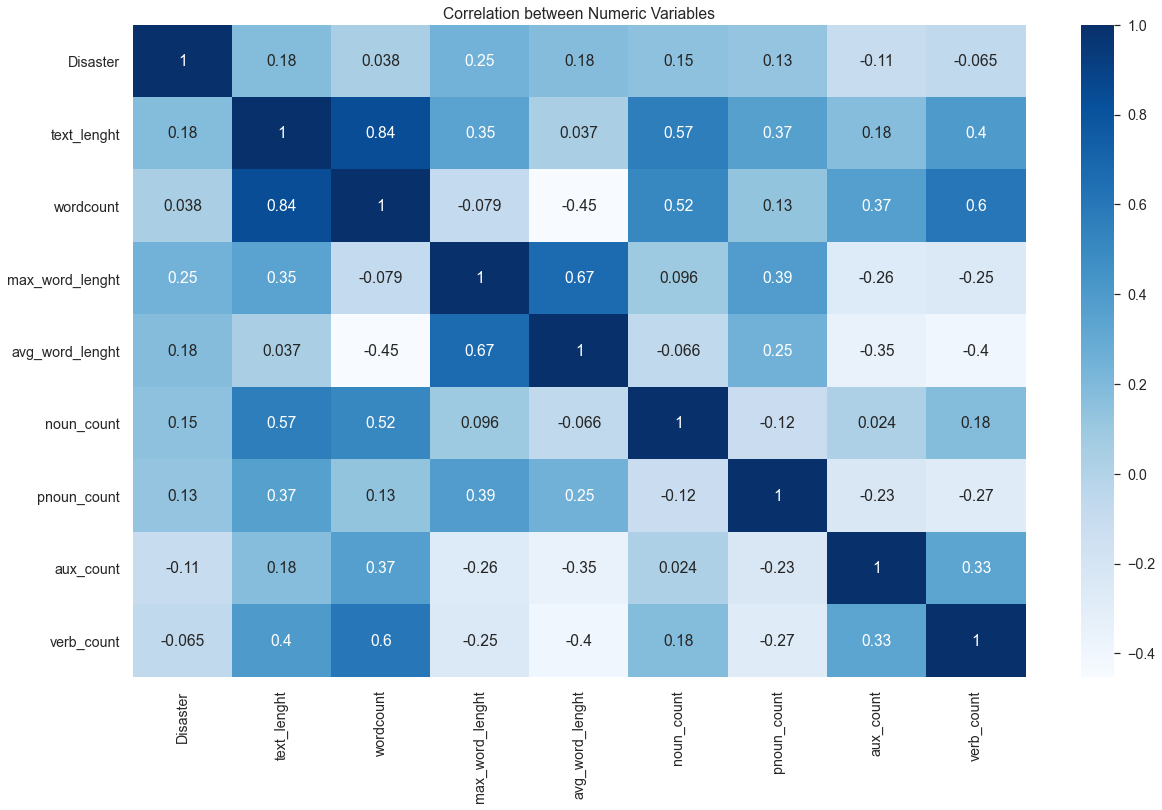

In [69]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.heatmap(train_subset.corr(), annot=True, ax=ax, cmap="Blues"); ax.set_title("Correlation between Numeric Variables");

<AxesSubplot:>

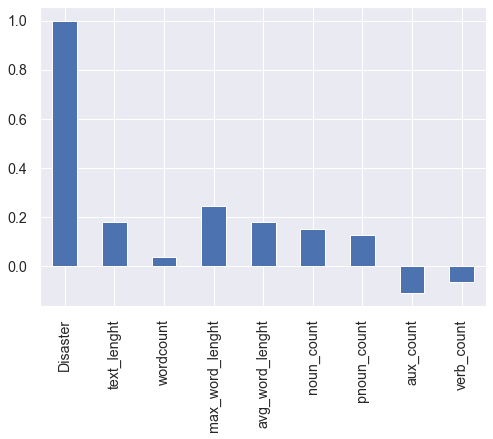

In [70]:
train_subset.corr()['Disaster'].plot(kind='bar')